In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse

In [2]:
import utilitis_FEEC.bsplines       as bsp
import utilitis_FEEC.projectors_mhd as mhd
import utilitis_FEEC.projectors     as proj
import utilitis_FEEC.derivatives    as der
import utilitis_FEEC.evaluation     as eva

import utilitis_FEEC.mass_matrices  as mass
import utilitis_FEEC.mappings       as maps

In [3]:
import utilitis_PIC.ECHO_fields
import utilitis_PIC.ECHO_pusher
import utilitis_PIC.ECHO_accumulation

In [4]:
#====================================================================================
#  calling epyccel for particle pusher
#====================================================================================
from pyccel.epyccel import epyccel

pic_fields = epyccel(utilitis_PIC.ECHO_fields)
pic_pusher = epyccel(utilitis_PIC.ECHO_pusher)
pic_accumu = epyccel(utilitis_PIC.ECHO_accumulation)

print('pyccelization done!')
#====================================================================================

pyccelization done!


In [124]:
Nel = [4, 4, 40]           # mesh generation on logical domain
bc  = [True, True, True]   # boundary conditions
p   = [2, 2, 2]            # splines degrees  
L   = [1., 1., 2*np.pi]    # box lengthes of physical domain


el_b      = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
T         = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors
t         = [T[1:-1] for T in T]                                               # reduced knot vectors
Nbase0    = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions in V0
Nbase_old = [Nel + p for Nel, p, bc in zip(Nel, p, bc)]                        # TODO delete this later
Ntot      = Nbase0[0] *Nbase0[1]*Nbase0[2]                                     # total number of basis functions
delta     = [1/Nel for Nel in Nel]                                             # element sizes


# geometry
DF      = np.array([[  L[0], 0., 0.], [0.,   L[1], 0.], [0., 0.,   L[2]]])
DFinv   = np.array([[1/L[0], 0., 0.], [0., 1/L[1], 0.], [0., 0., 1/L[2]]])

G       = np.array([[  L[0]**2, 0., 0.], [0.,   L[1]**2, 0.], [0., 0.,   L[2]**2]])
Ginv    = np.array([[1/L[0]**2, 0., 0.], [0., 1/L[1]**2, 0.], [0., 0., 1/L[2]**2]])

g_sqrt  = L[0]*L[1]*L[2]

mapping = maps.mappings(['slab', L[0], L[1], L[2]]) 

# time step
dt = 0.05


# coefficients for pp-forms in interval [0, delta] (N and D)
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
        

# background quantities
Ueq_phys = np.array([0., 0., 0.])     # background bulk flow (vector/1-form on physical domain)
Ueq      = DF.T.dot(Ueq_phys)         # background bulk flow (1-form on logical domain)


Beq_phys = np.array([0., 0., 1.])     # background magnetic field (vector/2-form on physical domain)
Beq      = g_sqrt*DFinv.dot(Beq_phys) # background magnetic field (2-form on logical domain)

B0_23    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (0.)
B0_31    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0.)   
B0_12    = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (1.)   

B0_hat   = [B0_23, B0_31, B0_12]

rho0_123 = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * (1.) # background bulk mass density on logical domain


# initial conditions
k   = 1.    # wavenumber of initial perturbation
amp = 1e-5  # amplitude  of initial perturbation

B1_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[0][0](q1, q2, q3) * (amp * np.sin(k * q3 *L[2]))
B2_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[1][1](q1, q2, q3) * (0. * q1)
B3_ini = lambda q1, q2, q3 : mapping.g_sqrt(q1, q2, q3) * mapping.DFinv[2][2](q1, q2, q3) * (0. * q1)

U1_ini = lambda q1, q2, q3 : mapping.DF[0][0](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U2_ini = lambda q1, q2, q3 : mapping.DF[1][1](q1, q2, q3) * (0. * q1)  # actually DF.T !!
U3_ini = lambda q1, q2, q3 : mapping.DF[2][2](q1, q2, q3) * (0. * q2)  # actually DF.T !!

In [125]:
# reserve memory for unknowns
b1,     b2,     b3     = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)
u1,     u2,     u3     = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)
u1_old, u2_old, u3_old = np.empty(Ntot), np.empty(Ntot), np.empty(Ntot)

b     = np.empty(3*Ntot, dtype=float)
u     = np.empty(3*Ntot, dtype=float)
u_old = np.empty(3*Ntot, dtype=float)

mat11 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat12 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat13 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

mat22 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat23 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
mat33 = np.empty((Nbase0[0], Nbase0[1], Nbase0[2], Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

vec1  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec2  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')
vec3  = np.empty((Nbase0[0], Nbase0[1], Nbase0[2]), dtype=float, order='F')

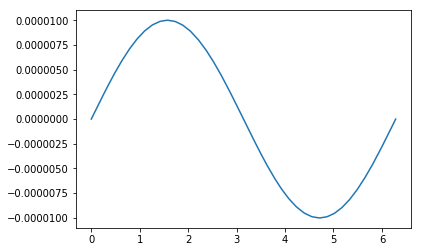

In [126]:
# create object for projecting initial conditions
PRO = proj.projectors_3d(p, Nbase_old, T, bc)

# left-hand sides of projectors
PRO.assemble_V1()
PRO.assemble_V2()

# projection of initial conditions
b1[:], b2[:], b3[:] = PRO.PI_2([B1_ini, B2_ini, B3_ini])
u1[:], u2[:], u3[:] = PRO.PI_1([U1_ini, U2_ini, U3_ini])

# plot initial condition on physical domain
q1plot = np.array([0.5])
q2plot = np.array([0.5])
q3plot = np.linspace(0., 1., 200)

Bini1, Bini2, Bini3 = eva.FEM_field_V2_3d([b1, b2, b3], [q1plot, q2plot, q3plot], T, p, bc)

plt.plot(q3plot*L[2], 1/g_sqrt*DF[0, 0]*Bini1)

In [127]:
# create object for projecting MHD matrices
MHD = mhd.projections_mhd(p, Nbase_old, T, bc)

# right-hand side of projection matrices
W1,   W2,   W3   = MHD.projection_W(rho0_123, mapping.g_sqrt)
TAU1, TAU2, TAU3 = MHD.projection_T(B0_hat, mapping.Ginv)

# mass matrices in V1 and V2
M1 = mass.mass_V1(T, p, bc, mapping.Ginv, mapping.g_sqrt)
M2 = mass.mass_V2(T, p, bc, mapping.G, mapping.g_sqrt)

# discrete curl and div matrices
derivatives = der.discrete_derivatives(p, T, bc)

CURL = derivatives.CURL_3d(T, p, bc)
DIV  = derivatives.DIV_3d(T, p, bc)

# perform projections of TAU1, TAU2, TAU3
TAU1 = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, TAU1)
TAU2 = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, TAU2)
TAU3 = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, TAU3)

TAU  = sparse.bmat([[TAU1], [TAU2], [TAU3]], format='csc')

# perform projections of W1, W2, W3
W1   = sparse.linalg.spsolve(PRO.interhistopolation_V1_1, W1)
W2   = sparse.linalg.spsolve(PRO.interhistopolation_V1_2, W2)
W3   = sparse.linalg.spsolve(PRO.interhistopolation_V1_3, W3)

W    = sparse.bmat([[W1, None, None], [None, W2, None], [None, None, W3]], format='csc')

# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1))

# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

A = A.toarray()

In [134]:
import sobol_seq
import scipy.special as sp
 

Np  = int(2e5)         # total number of particles
vth = 1.               # thermal velocity of particles in all directions
v0  = 2.               # mean velocity of particles in z-direction
nuh = 0.05             # ratio of hot/cold mass densities        
nh0 = (1.)*nuh*g_sqrt  # hot ion number density on logical domain

# create particles with random numbers
particles        = np.empty((Np, 7), dtype=float, order='F')

#particles[:, :6] = sobol_seq.i4_sobol_generate(6, Np)
particles[:, :6] = np.random.rand(Np, 6)

# transform velocities to Maxwellians
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0

# compute weights
particles[:, 6]  = nh0/Np 


# compute spans
spans0       = np.empty((Np, 3), dtype=int, order='F')
spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]

# empty matrices for fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

(array([7.0000e+00, 1.9000e+01, 3.6000e+01, 1.3800e+02, 2.9800e+02,
        7.2300e+02, 1.5590e+03, 2.8350e+03, 5.0900e+03, 8.0310e+03,
        1.1782e+04, 1.5960e+04, 1.9587e+04, 2.2294e+04, 2.3128e+04,
        2.2236e+04, 1.9776e+04, 1.5739e+04, 1.1945e+04, 8.0270e+03,
        5.0710e+03, 2.9160e+03, 1.5320e+03, 7.0500e+02, 3.3600e+02,
        1.4800e+02, 5.6000e+01, 2.1000e+01, 2.0000e+00]),
 array([-1.        , -0.79310345, -0.5862069 , -0.37931034, -0.17241379,
         0.03448276,  0.24137931,  0.44827586,  0.65517241,  0.86206897,
         1.06896552,  1.27586207,  1.48275862,  1.68965517,  1.89655172,
         2.10344828,  2.31034483,  2.51724138,  2.72413793,  2.93103448,
         3.13793103,  3.34482759,  3.55172414,  3.75862069,  3.96551724,
         4.17241379,  4.37931034,  4.5862069 ,  4.79310345,  5.        ]),
 <a list of 29 Patch objects>)

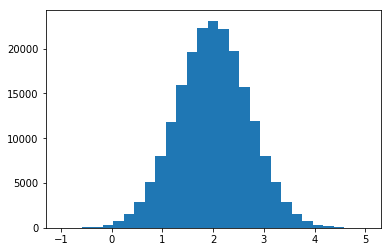

In [136]:
plt.hist(particles[:, 5], bins = np.linspace(-1., 5., 30))

In [147]:
b[:] = np.concatenate((b1, b2, b3))
u[:] = np.concatenate((u1, u2, u3))


# compute initial fields at particle positions
pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(u[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(u[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)


# initial energies
en_U = 1/2*u.dot(A.dot(u))
en_B = 1/2*b.dot(M2.dot(b))
en_H = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)

energies = np.array([en_U, en_B, en_H])

In [71]:
def update():
    
    # step 1 (update u)
    pic_accumu.accumulation_step1(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat12, mat13, mat23)
    
    AJ11A = np.block([[np.zeros((Ntot, Ntot)), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [-mat12.reshape(Ntot, Ntot), np.zeros((Ntot, Ntot)), mat23.reshape(Ntot, Ntot)], [-mat13.reshape(Ntot, Ntot), -mat23.reshape(Ntot, Ntot), np.zeros((Ntot, Ntot))]])
    
    u[:] = np.linalg.solve(A - dt/2*AJ11A, (A + dt/2*AJ11A).dot(u))
    
    
    # step 2 (update first u, then b and evaluate B-field at particle positions)
    u_old[:] = u
    
    u[:] = STEP2_schur_LU.solve(STEP2_1.dot(u_old) + STEP2_2.dot(b))
    b[:] = b - dt/2*CURL.dot(TAU.dot(u_old + u))
    
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    
    
    # step 3 (update first u, then evaluate U-field at particle positions and then update V)
    pic_accumu.accumulation_step3(particles, p, spans0, Nbase0, T[0], T[1], T[2], t[0], t[1], t[2], L, B_part, mat11, mat12, mat13, mat22, mat23, mat33, vec1, vec2, vec3)
    
    BLOCK = np.block([[mat11.reshape(Ntot, Ntot), mat12.reshape(Ntot, Ntot), mat13.reshape(Ntot, Ntot)], [mat12.reshape(Ntot, Ntot), mat22.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot)], [mat13.reshape(Ntot, Ntot), mat23.reshape(Ntot, Ntot), mat33.reshape(Ntot, Ntot)]])
    
    u_old[:] = u
    
    u[:] = np.linalg.solve(A + dt**2/4*BLOCK, (A - dt**2/4*BLOCK).dot(u_old) + dt*np.concatenate((vec1.flatten(), vec2.flatten(), vec3.flatten())))
    
    pic_fields.evaluate_1form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(1/2*(u + u_old)[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(1/2*(u + u_old)[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Ueq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part)
    
    pic_pusher.pusher_step3(particles, L, dt, B_part, U_part)
    
    # step 4 (update Q and spans)
    pic_pusher.pusher_step4(particles, L, dt)
    
    spans0[:, 0] = np.floor(particles[:, 0]*Nel[0]).astype(int) + p[0]
    spans0[:, 1] = np.floor(particles[:, 1]*Nel[1]).astype(int) + p[1]
    spans0[:, 2] = np.floor(particles[:, 2]*Nel[2]).astype(int) + p[2]
    
    # step 5 (update V)
    pic_fields.evaluate_2form(particles[:, 0:3], p, spans0, Nbase0, Np, np.asfortranarray(b[:Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[Ntot:2*Ntot].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), np.asfortranarray(b[2*Ntot:].reshape(Nbase0[0], Nbase0[1], Nbase0[2])), Beq, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part)
    pic_pusher.pusher_step5(particles, L, dt, B_part)

In [72]:
Nt = 8000

for n in range(Nt):
    
    print('steps done', n)
    
    update()
    
    # compute energies
    en_U = 1/2*u.dot(A.dot(u))
    en_B = 1/2*b.dot(M2.dot(b))
    en_H = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)
    
    energies = np.vstack((energies, np.array([en_U, en_B, en_H])))
    print(energies[n + 1])

steps done 0
[1.07561196e-09 1.56686860e-10 8.63905539e-01]
steps done 1
[5.29167626e-09 3.66383764e-10 8.63905534e-01]
steps done 2
[1.25224135e-08 1.77365199e-09 8.63905526e-01]
steps done 3
[2.03918950e-08 5.40905400e-09 8.63905514e-01]
steps done 4
[2.83759615e-08 1.04419524e-08 8.63905501e-01]
steps done 5
[3.55792467e-08 1.66582048e-08 8.63905488e-01]
steps done 6
[4.66404349e-08 2.35864610e-08 8.63905470e-01]
steps done 7
[5.62828589e-08 3.19722173e-08 8.63905452e-01]
steps done 8
[6.52681849e-08 4.45855590e-08 8.63905430e-01]
steps done 9
[7.80149055e-08 5.85162974e-08 8.63905403e-01]
steps done 10
[9.61972780e-08 7.03928506e-08 8.63905373e-01]
steps done 11
[1.19700664e-07 8.48567769e-08 8.63905335e-01]
steps done 12
[1.49339149e-07 1.02362794e-07 8.63905288e-01]
steps done 13
[1.84517334e-07 1.23327833e-07 8.63905232e-01]
steps done 14
[2.24158010e-07 1.49721381e-07 8.63905166e-01]
steps done 15
[2.57782033e-07 1.82707697e-07 8.63905100e-01]
steps done 16
[2.98570136e-07 2.14

[3.32169346e-06 3.02029074e-06 8.63899237e-01]
steps done 135
[3.29970785e-06 3.07212094e-06 8.63899208e-01]
steps done 136
[3.25754026e-06 3.16257677e-06 8.63899161e-01]
steps done 137
[3.17179998e-06 3.27931564e-06 8.63899130e-01]
steps done 138
[3.13251374e-06 3.33404965e-06 8.63899115e-01]
steps done 139
[3.11758072e-06 3.36165163e-06 8.63899102e-01]
steps done 140
[3.13196485e-06 3.37365162e-06 8.63899076e-01]
steps done 141
[3.23087506e-06 3.32249315e-06 8.63899028e-01]
steps done 142
[3.39394480e-06 3.22298217e-06 8.63898965e-01]
steps done 143
[3.52350153e-06 3.15930091e-06 8.63898900e-01]
steps done 144
[3.59062943e-06 3.14046798e-06 8.63898853e-01]
steps done 145
[3.55095059e-06 3.19217283e-06 8.63898841e-01]
steps done 146
[3.42515222e-06 3.30886359e-06 8.63898852e-01]
steps done 147
[3.34510642e-06 3.41652480e-06 8.63898825e-01]
steps done 148
[3.32591134e-06 3.48837842e-06 8.63898773e-01]
steps done 149
[3.31012246e-06 3.53417562e-06 8.63898743e-01]
steps done 150
[3.40123

[6.04436104e-06 6.23511379e-06 8.63893464e-01]
steps done 268
[5.94753419e-06 6.37362355e-06 8.63893421e-01]
steps done 269
[5.98426987e-06 6.37069331e-06 8.63893387e-01]
steps done 270
[6.11380218e-06 6.29517475e-06 8.63893332e-01]
steps done 271
[6.18157098e-06 6.23340194e-06 8.63893325e-01]
steps done 272
[6.25893755e-06 6.17489387e-06 8.63893305e-01]
steps done 273
[6.40096548e-06 6.07720986e-06 8.63893261e-01]
steps done 274
[6.52071472e-06 6.00571071e-06 8.63893213e-01]
steps done 275
[6.54298887e-06 6.00034936e-06 8.63893198e-01]
steps done 276
[6.43294940e-06 6.07325476e-06 8.63893236e-01]
steps done 277
[6.32006244e-06 6.19166927e-06 8.63893232e-01]
steps done 278
[6.19573247e-06 6.34931248e-06 8.63893200e-01]
steps done 279
[6.09095538e-06 6.47810594e-06 8.63893177e-01]
steps done 280
[6.05603575e-06 6.49536138e-06 8.63893196e-01]
steps done 281
[6.05067238e-06 6.46092833e-06 8.63893236e-01]
steps done 282
[6.06311016e-06 6.44887652e-06 8.63893235e-01]
steps done 283
[6.14945

[9.61303741e-06 1.02794875e-05 8.63886129e-01]
steps done 401
[9.94134612e-06 9.97174649e-06 8.63886112e-01]
steps done 402
[1.00867977e-05 9.79223494e-06 8.63886149e-01]
steps done 403
[1.01685009e-05 9.68528544e-06 8.63886177e-01]
steps done 404
[1.02903658e-05 9.59448235e-06 8.63886149e-01]
steps done 405
[1.02859924e-05 9.67901116e-06 8.63886072e-01]
steps done 406
[1.01310416e-05 9.93267526e-06 8.63885976e-01]
steps done 407
[1.00197135e-05 1.01365842e-05 8.63885887e-01]
steps done 408
[1.00282168e-05 1.01930077e-05 8.63885825e-01]
steps done 409
[1.02156549e-05 1.01052816e-05 8.63885727e-01]
steps done 410
[1.05665815e-05 9.88931872e-06 8.63885595e-01]
steps done 411
[1.09034805e-05 9.69300894e-06 8.63885457e-01]
steps done 412
[1.10607408e-05 9.64687163e-06 8.63885350e-01]
steps done 413
[1.10906101e-05 9.72589406e-06 8.63885245e-01]
steps done 414
[1.10178433e-05 9.90053702e-06 8.63885148e-01]
steps done 415
[1.08281699e-05 1.01655087e-05 8.63885078e-01]
steps done 416
[1.05689

[1.39185697e-05 1.42101199e-05 8.63878368e-01]
steps done 534
[1.40543682e-05 1.41663749e-05 8.63878278e-01]
steps done 535
[1.43425513e-05 1.40053462e-05 8.63878152e-01]
steps done 536
[1.45563943e-05 1.39435672e-05 8.63878000e-01]
steps done 537
[1.46546590e-05 1.39770279e-05 8.63877868e-01]
steps done 538
[1.46746001e-05 1.39839510e-05 8.63877842e-01]
steps done 539
[1.45605087e-05 1.41064800e-05 8.63877836e-01]
steps done 540
[1.42908439e-05 1.43817577e-05 8.63877833e-01]
steps done 541
[1.41371619e-05 1.45355407e-05 8.63877837e-01]
steps done 542
[1.41260381e-05 1.45587841e-05 8.63877830e-01]
steps done 543
[1.40259949e-05 1.46777681e-05 8.63877817e-01]
steps done 544
[1.39612294e-05 1.48090628e-05 8.63877758e-01]
steps done 545
[1.39658995e-05 1.48842582e-05 8.63877686e-01]
steps done 546
[1.38189973e-05 1.50921527e-05 8.63877632e-01]
steps done 547
[1.35350705e-05 1.53580299e-05 8.63877656e-01]
steps done 548
[1.35227836e-05 1.53620754e-05 8.63877670e-01]
steps done 549
[1.37338

[1.75040157e-05 1.81354194e-05 8.63871538e-01]
steps done 667
[1.73283973e-05 1.83440178e-05 8.63871509e-01]
steps done 668
[1.72309619e-05 1.84967748e-05 8.63871460e-01]
steps done 669
[1.75598777e-05 1.82815336e-05 8.63871354e-01]
steps done 670
[1.81057869e-05 1.78119839e-05 8.63871288e-01]
steps done 671
[1.84362541e-05 1.75295159e-05 8.63871252e-01]
steps done 672
[1.84790550e-05 1.75389403e-05 8.63871214e-01]
steps done 673
[1.83677448e-05 1.76713341e-05 8.63871208e-01]
steps done 674
[1.83285686e-05 1.77907102e-05 8.63871141e-01]
steps done 675
[1.84441188e-05 1.77729887e-05 8.63871056e-01]
steps done 676
[1.87404458e-05 1.76015940e-05 8.63870943e-01]
steps done 677
[1.89719391e-05 1.75372380e-05 8.63870787e-01]
steps done 678
[1.89501285e-05 1.77424732e-05 8.63870614e-01]
steps done 679
[1.88501141e-05 1.80613391e-05 8.63870404e-01]
steps done 680
[1.87382194e-05 1.83926996e-05 8.63870194e-01]
steps done 681
[1.86488356e-05 1.87314161e-05 8.63869955e-01]
steps done 682
[1.84486

[2.53455850e-05 2.23478604e-05 8.63860905e-01]
steps done 800
[2.54510804e-05 2.23513978e-05 8.63860820e-01]
steps done 801
[2.55103430e-05 2.24843496e-05 8.63860652e-01]
steps done 802
[2.53639092e-05 2.28425104e-05 8.63860461e-01]
steps done 803
[2.48100907e-05 2.35834032e-05 8.63860292e-01]
steps done 804
[2.40090937e-05 2.45789925e-05 8.63860111e-01]
steps done 805
[2.33456521e-05 2.54487525e-05 8.63859918e-01]
steps done 806
[2.29770125e-05 2.59395494e-05 8.63859808e-01]
steps done 807
[2.28518311e-05 2.61375245e-05 8.63859747e-01]
steps done 808
[2.27831222e-05 2.62675503e-05 8.63859697e-01]
steps done 809
[2.27813877e-05 2.62551049e-05 8.63859726e-01]
steps done 810
[2.31881099e-05 2.58070340e-05 8.63859785e-01]
steps done 811
[2.38507233e-05 2.51494559e-05 8.63859802e-01]
steps done 812
[2.43391352e-05 2.47574666e-05 8.63859729e-01]
steps done 813
[2.47088122e-05 2.44957811e-05 8.63859647e-01]
steps done 814
[2.52461239e-05 2.40135820e-05 8.63859619e-01]
steps done 815
[2.58311

[3.02006711e-05 2.98785763e-05 8.63850374e-01]
steps done 933
[2.98271265e-05 3.02823532e-05 8.63850365e-01]
steps done 934
[2.95090067e-05 3.05968049e-05 8.63850389e-01]
steps done 935
[2.95179662e-05 3.06613173e-05 8.63850334e-01]
steps done 936
[2.97838413e-05 3.05303014e-05 8.63850217e-01]
steps done 937
[3.01650565e-05 3.02529061e-05 8.63850132e-01]
steps done 938
[3.06391201e-05 2.98164973e-05 8.63850116e-01]
steps done 939
[3.08453705e-05 2.96585761e-05 8.63850092e-01]
steps done 940
[3.04727185e-05 3.01744879e-05 8.63849974e-01]
steps done 941
[2.99006827e-05 3.09229755e-05 8.63849823e-01]
steps done 942
[2.96814669e-05 3.12170782e-05 8.63849772e-01]
steps done 943
[2.97605491e-05 3.11511344e-05 8.63849780e-01]
steps done 944
[2.99303450e-05 3.10197898e-05 8.63849760e-01]
steps done 945
[3.04484873e-05 3.06173278e-05 8.63849660e-01]
steps done 946
[3.12775670e-05 2.99339160e-05 8.63849528e-01]
steps done 947
[3.17949568e-05 2.96144876e-05 8.63849345e-01]
steps done 948
[3.17521

[3.87500175e-05 3.43127716e-05 8.63839760e-01]
steps done 1065
[3.80819898e-05 3.51703917e-05 8.63839598e-01]
steps done 1066
[3.73737941e-05 3.60436074e-05 8.63839456e-01]
steps done 1067
[3.67410722e-05 3.67773746e-05 8.63839376e-01]
steps done 1068
[3.62200631e-05 3.73548077e-05 8.63839337e-01]
steps done 1069
[3.58821120e-05 3.76450014e-05 8.63839399e-01]
steps done 1070
[3.57546523e-05 3.77511876e-05 8.63839433e-01]
steps done 1071
[3.57190314e-05 3.78712500e-05 8.63839362e-01]
steps done 1072
[3.58348341e-05 3.78885549e-05 8.63839246e-01]
steps done 1073
[3.63861017e-05 3.74908693e-05 8.63839115e-01]
steps done 1074
[3.69212042e-05 3.70359348e-05 8.63839063e-01]
steps done 1075
[3.68835510e-05 3.70608039e-05 8.63839109e-01]
steps done 1076
[3.66920885e-05 3.72854571e-05 8.63839111e-01]
steps done 1077
[3.68282659e-05 3.72436416e-05 8.63839054e-01]
steps done 1078
[3.69433981e-05 3.72244183e-05 8.63838994e-01]
steps done 1079
[3.68022478e-05 3.74659135e-05 8.63838926e-01]
steps do

[4.38716235e-05 4.64474469e-05 8.63826516e-01]
steps done 1196
[4.40983818e-05 4.65446267e-05 8.63826230e-01]
steps done 1197
[4.45595122e-05 4.64858915e-05 8.63825866e-01]
steps done 1198
[4.50452892e-05 4.63437392e-05 8.63825562e-01]
steps done 1199
[4.53202290e-05 4.62765019e-05 8.63825393e-01]
steps done 1200
[4.55367589e-05 4.61592099e-05 8.63825333e-01]
steps done 1201
[4.58067062e-05 4.60151046e-05 8.63825247e-01]
steps done 1202
[4.56992237e-05 4.60930190e-05 8.63825316e-01]
steps done 1203
[4.53612652e-05 4.63942268e-05 8.63825392e-01]
steps done 1204
[4.54439178e-05 4.64524925e-05 8.63825292e-01]
steps done 1205
[4.58726213e-05 4.62383466e-05 8.63825119e-01]
steps done 1206
[4.59955897e-05 4.62744406e-05 8.63825001e-01]
steps done 1207
[4.58084958e-05 4.65600774e-05 8.63824944e-01]
steps done 1208
[4.59418384e-05 4.65260666e-05 8.63824887e-01]
steps done 1209
[4.65525407e-05 4.60037282e-05 8.63824842e-01]
steps done 1210
[4.73469492e-05 4.53013374e-05 8.63824795e-01]
steps do

[5.54692292e-05 5.45765528e-05 8.63812309e-01]
steps done 1327
[5.59974327e-05 5.41036179e-05 8.63812309e-01]
steps done 1328
[5.68453077e-05 5.33105468e-05 8.63812311e-01]
steps done 1329
[5.77936225e-05 5.24621854e-05 8.63812272e-01]
steps done 1330
[5.81749613e-05 5.21216352e-05 8.63812296e-01]
steps done 1331
[5.78143472e-05 5.24808419e-05 8.63812362e-01]
steps done 1332
[5.69572913e-05 5.33536573e-05 8.63812410e-01]
steps done 1333
[5.59312151e-05 5.44746452e-05 8.63812374e-01]
steps done 1334
[5.49692606e-05 5.55819097e-05 8.63812282e-01]
steps done 1335
[5.43428749e-05 5.63378369e-05 8.63812200e-01]
steps done 1336
[5.42018822e-05 5.66251817e-05 8.63812096e-01]
steps done 1337
[5.43756643e-05 5.65618798e-05 8.63812025e-01]
steps done 1338
[5.49713818e-05 5.60865386e-05 8.63811946e-01]
steps done 1339
[5.62515142e-05 5.50135306e-05 8.63811784e-01]
steps done 1340
[5.79481596e-05 5.36433619e-05 8.63811508e-01]
steps done 1341
[5.90860228e-05 5.28403584e-05 8.63811228e-01]
steps do

[6.35211443e-05 7.41671027e-05 8.63792517e-01]
steps done 1458
[6.44167739e-05 7.34636634e-05 8.63792389e-01]
steps done 1459
[6.60107061e-05 7.21863826e-05 8.63792142e-01]
steps done 1460
[6.76609138e-05 7.08898897e-05 8.63791862e-01]
steps done 1461
[6.88656500e-05 6.99848110e-05 8.63791639e-01]
steps done 1462
[6.95885236e-05 6.96593884e-05 8.63791318e-01]
steps done 1463
[6.98997434e-05 6.97380215e-05 8.63791006e-01]
steps done 1464
[7.02237102e-05 6.97861134e-05 8.63790712e-01]
steps done 1465
[7.06293494e-05 6.97588498e-05 8.63790410e-01]
steps done 1466
[7.07104620e-05 7.00772871e-05 8.63790087e-01]
steps done 1467
[7.03315274e-05 7.08482365e-05 8.63789773e-01]
steps done 1468
[6.97514752e-05 7.17695978e-05 8.63789510e-01]
steps done 1469
[6.92795495e-05 7.25588725e-05 8.63789269e-01]
steps done 1470
[6.93450583e-05 7.27340625e-05 8.63789101e-01]
steps done 1471
[7.04978723e-05 7.17635921e-05 8.63788989e-01]
steps done 1472
[7.26646433e-05 6.99144654e-05 8.63788743e-01]
steps do

[9.27815386e-05 8.19962325e-05 8.63765995e-01]
steps done 1589
[9.13641775e-05 8.37997017e-05 8.63765720e-01]
steps done 1590
[8.94721680e-05 8.61941384e-05 8.63765326e-01]
steps done 1591
[8.73875796e-05 8.87467215e-05 8.63764962e-01]
steps done 1592
[8.55377114e-05 9.10784459e-05 8.63764576e-01]
steps done 1593
[8.41706393e-05 9.28528659e-05 8.63764256e-01]
steps done 1594
[8.37087488e-05 9.35605172e-05 8.63764092e-01]
steps done 1595
[8.46218024e-05 9.27602363e-05 8.63764059e-01]
steps done 1596
[8.70185051e-05 9.04604590e-05 8.63764045e-01]
steps done 1597
[9.04724786e-05 8.71785523e-05 8.63763963e-01]
steps done 1598
[9.39856881e-05 8.40221736e-05 8.63763708e-01]
steps done 1599
[9.61775559e-05 8.23356838e-05 8.63763318e-01]
steps done 1600
[9.63346100e-05 8.26319299e-05 8.63762993e-01]
steps done 1601
[9.50738910e-05 8.42437666e-05 8.63762777e-01]
steps done 1602
[9.30703734e-05 8.65457515e-05 8.63762610e-01]
steps done 1603
[9.03206105e-05 8.95856114e-05 8.63762442e-01]
steps do

[1.14609339e-04 1.01191639e-04 8.63738565e-01]
steps done 1720
[1.17925278e-04 9.83326694e-05 8.63738228e-01]
steps done 1721
[1.20205086e-04 9.65895801e-05 8.63737824e-01]
steps done 1722
[1.20867793e-04 9.64509417e-05 8.63737438e-01]
steps done 1723
[1.19528525e-04 9.83805328e-05 8.63736985e-01]
steps done 1724
[1.16285326e-04 1.02102735e-04 8.63736638e-01]
steps done 1725
[1.12264589e-04 1.06526269e-04 8.63736358e-01]
steps done 1726
[1.08799372e-04 1.10510123e-04 8.63735949e-01]
steps done 1727
[1.06266343e-04 1.13525396e-04 8.63735560e-01]
steps done 1728
[1.04952392e-04 1.15240231e-04 8.63735243e-01]
steps done 1729
[1.05884006e-04 1.14857010e-04 8.63734772e-01]
steps done 1730
[1.09512590e-04 1.11811404e-04 8.63734269e-01]
steps done 1731
[1.14943336e-04 1.06925928e-04 8.63733813e-01]
steps done 1732
[1.20555889e-04 1.01895752e-04 8.63733334e-01]
steps done 1733
[1.24736325e-04 9.83472746e-05 8.63732822e-01]
steps done 1734
[1.25885004e-04 9.77459940e-05 8.63732409e-01]
steps do

[1.47019713e-04 1.36339202e-04 8.63688234e-01]
steps done 1851
[1.44430723e-04 1.39565484e-04 8.63687752e-01]
steps done 1852
[1.42856943e-04 1.41725207e-04 8.63687315e-01]
steps done 1853
[1.42609599e-04 1.42668002e-04 8.63686763e-01]
steps done 1854
[1.42520790e-04 1.43455037e-04 8.63686200e-01]
steps done 1855
[1.42488450e-04 1.44141894e-04 8.63685676e-01]
steps done 1856
[1.44078938e-04 1.43046686e-04 8.63685307e-01]
steps done 1857
[1.47973478e-04 1.39577535e-04 8.63685013e-01]
steps done 1858
[1.52378123e-04 1.35467305e-04 8.63684861e-01]
steps done 1859
[1.55321637e-04 1.32941480e-04 8.63684599e-01]
steps done 1860
[1.56033988e-04 1.32737637e-04 8.63684258e-01]
steps done 1861
[1.54371474e-04 1.34946668e-04 8.63683886e-01]
steps done 1862
[1.50395319e-04 1.39589359e-04 8.63683393e-01]
steps done 1863
[1.45242156e-04 1.45494918e-04 8.63682801e-01]
steps done 1864
[1.41104237e-04 1.50404717e-04 8.63682169e-01]
steps done 1865
[1.39436872e-04 1.52738074e-04 8.63681623e-01]
steps do

[2.03850563e-04 1.69090582e-04 8.63619860e-01]
steps done 1982
[2.02844054e-04 1.70965008e-04 8.63619194e-01]
steps done 1983
[1.99677952e-04 1.75167310e-04 8.63618354e-01]
steps done 1984
[1.95424198e-04 1.80265637e-04 8.63617693e-01]
steps done 1985
[1.90451401e-04 1.85884742e-04 8.63617214e-01]
steps done 1986
[1.85825457e-04 1.91063940e-04 8.63616811e-01]
steps done 1987
[1.83610391e-04 1.94001693e-04 8.63616225e-01]
steps done 1988
[1.84538472e-04 1.93807076e-04 8.63615619e-01]
steps done 1989
[1.87713920e-04 1.91407163e-04 8.63614970e-01]
steps done 1990
[1.91651374e-04 1.88408511e-04 8.63614168e-01]
steps done 1991
[1.95505444e-04 1.85665929e-04 8.63613211e-01]
steps done 1992
[1.98655156e-04 1.83624441e-04 8.63612275e-01]
steps done 1993
[2.00147134e-04 1.83060034e-04 8.63611536e-01]
steps done 1994
[1.99483091e-04 1.84609603e-04 8.63610852e-01]
steps done 1995
[1.96798146e-04 1.88079410e-04 8.63610272e-01]
steps done 1996
[1.92609447e-04 1.92879039e-04 8.63609860e-01]
steps do

[2.36210728e-04 2.52701387e-04 8.63529133e-01]
steps done 2113
[2.38438647e-04 2.51213277e-04 8.63528571e-01]
steps done 2114
[2.43172896e-04 2.47237551e-04 8.63527994e-01]
steps done 2115
[2.50165834e-04 2.41191393e-04 8.63527243e-01]
steps done 2116
[2.57343395e-04 2.35155372e-04 8.63526315e-01]
steps done 2117
[2.62173655e-04 2.31544587e-04 8.63525324e-01]
steps done 2118
[2.63909357e-04 2.30718585e-04 8.63524652e-01]
steps done 2119
[2.63347541e-04 2.32077851e-04 8.63524096e-01]
steps done 2120
[2.60497238e-04 2.35897036e-04 8.63523364e-01]
steps done 2121
[2.55138151e-04 2.42068051e-04 8.63522778e-01]
steps done 2122
[2.48848153e-04 2.49069671e-04 8.63522272e-01]
steps done 2123
[2.43843088e-04 2.54895977e-04 8.63521634e-01]
steps done 2124
[2.41729510e-04 2.57887015e-04 8.63520924e-01]
steps done 2125
[2.43977845e-04 2.56621495e-04 8.63520105e-01]
steps done 2126
[2.50839303e-04 2.50968831e-04 8.63519072e-01]
steps done 2127
[2.60341515e-04 2.42803154e-04 8.63517932e-01]
steps do

[3.22586244e-04 3.18314665e-04 8.63408891e-01]
steps done 2244
[3.16921304e-04 3.25341782e-04 8.63407779e-01]
steps done 2245
[3.14029018e-04 3.29566840e-04 8.63406681e-01]
steps done 2246
[3.15827453e-04 3.29011854e-04 8.63405662e-01]
steps done 2247
[3.22171501e-04 3.23845674e-04 8.63404709e-01]
steps done 2248
[3.31541596e-04 3.15680785e-04 8.63403741e-01]
steps done 2249
[3.42046185e-04 3.06534383e-04 8.63402644e-01]
steps done 2250
[3.50908976e-04 2.99247486e-04 8.63401352e-01]
steps done 2251
[3.55343943e-04 2.96582391e-04 8.63399888e-01]
steps done 2252
[3.54159588e-04 2.99547987e-04 8.63398423e-01]
steps done 2253
[3.48167105e-04 3.07062643e-04 8.63397216e-01]
steps done 2254
[3.40540607e-04 3.16129375e-04 8.63396076e-01]
steps done 2255
[3.34673141e-04 3.23613730e-04 8.63394737e-01]
steps done 2256
[3.30623303e-04 3.29255536e-04 8.63393400e-01]
steps done 2257
[3.26876106e-04 3.34477126e-04 8.63392161e-01]
steps done 2258
[3.25036738e-04 3.37777661e-04 8.63390926e-01]
steps do

[4.40587566e-04 3.98161806e-04 8.63251879e-01]
steps done 2375
[4.43848223e-04 3.96618738e-04 8.63250542e-01]
steps done 2376
[4.44378238e-04 3.97672808e-04 8.63249344e-01]
steps done 2377
[4.41379355e-04 4.02340097e-04 8.63248056e-01]
steps done 2378
[4.36150507e-04 4.09421583e-04 8.63246565e-01]
steps done 2379
[4.31221767e-04 4.16032599e-04 8.63245222e-01]
steps done 2380
[4.30332958e-04 4.18504838e-04 8.63243959e-01]
steps done 2381
[4.35241681e-04 4.15230637e-04 8.63242636e-01]
steps done 2382
[4.43337855e-04 4.08567314e-04 8.63241524e-01]
steps done 2383
[4.50589003e-04 4.02810243e-04 8.63240361e-01]
steps done 2384
[4.55043615e-04 4.00057585e-04 8.63239002e-01]
steps done 2385
[4.57181900e-04 3.99516613e-04 8.63237757e-01]
steps done 2386
[4.58444352e-04 3.99852344e-04 8.63236520e-01]
steps done 2387
[4.58458627e-04 4.01495063e-04 8.63235228e-01]
steps done 2388
[4.56074569e-04 4.05553880e-04 8.63233918e-01]
steps done 2389
[4.51551443e-04 4.11585011e-04 8.63232771e-01]
steps do

[5.63878665e-04 5.21336293e-04 8.63057208e-01]
steps done 2506
[5.67967601e-04 5.19064051e-04 8.63055808e-01]
steps done 2507
[5.74346327e-04 5.14497153e-04 8.63054418e-01]
steps done 2508
[5.81414505e-04 5.09136872e-04 8.63053146e-01]
steps done 2509
[5.85990439e-04 5.06240055e-04 8.63051918e-01]
steps done 2510
[5.85579679e-04 5.08606917e-04 8.63050425e-01]
steps done 2511
[5.80787811e-04 5.15494434e-04 8.63048791e-01]
steps done 2512
[5.74129267e-04 5.24248798e-04 8.63047144e-01]
steps done 2513
[5.66932170e-04 5.33435627e-04 8.63045587e-01]
steps done 2514
[5.60362012e-04 5.42016684e-04 8.63043987e-01]
steps done 2515
[5.56775483e-04 5.47556901e-04 8.63042426e-01]
steps done 2516
[5.58867499e-04 5.47288455e-04 8.63040989e-01]
steps done 2517
[5.66886013e-04 5.41182335e-04 8.63039473e-01]
steps done 2518
[5.77360625e-04 5.32439742e-04 8.63038164e-01]
steps done 2519
[5.85817315e-04 5.25624543e-04 8.63036975e-01]
steps done 2520
[5.89833562e-04 5.23276097e-04 8.63035787e-01]
steps do

[6.97388089e-04 6.53122676e-04 8.62856040e-01]
steps done 2637
[6.92204255e-04 6.60018166e-04 8.62854886e-01]
steps done 2638
[6.87563989e-04 6.66280624e-04 8.62853807e-01]
steps done 2639
[6.85349083e-04 6.70311403e-04 8.62852524e-01]
steps done 2640
[6.87328560e-04 6.70234126e-04 8.62851151e-01]
steps done 2641
[6.93437976e-04 6.66049802e-04 8.62849758e-01]
steps done 2642
[7.02762774e-04 6.58622939e-04 8.62848404e-01]
steps done 2643
[7.14079152e-04 6.49363554e-04 8.62846915e-01]
steps done 2644
[7.23156612e-04 6.42511167e-04 8.62845289e-01]
steps done 2645
[7.25299011e-04 6.42555578e-04 8.62843722e-01]
steps done 2646
[7.20618724e-04 6.49190601e-04 8.62842387e-01]
steps done 2647
[7.12882426e-04 6.58769616e-04 8.62841141e-01]
steps done 2648
[7.05260518e-04 6.68349159e-04 8.62839749e-01]
steps done 2649
[6.99998320e-04 6.75795644e-04 8.62838100e-01]
steps done 2650
[6.98730448e-04 6.79447564e-04 8.62836233e-01]
steps done 2651
[7.00252187e-04 6.79899089e-04 8.62834766e-01]
steps do

[8.77213376e-04 7.55289674e-04 8.62653920e-01]
steps done 2768
[8.72520532e-04 7.61888183e-04 8.62652791e-01]
steps done 2769
[8.62435076e-04 7.73783310e-04 8.62651736e-01]
steps done 2770
[8.46795570e-04 7.91346778e-04 8.62650524e-01]
steps done 2771
[8.29668026e-04 8.10589200e-04 8.62649071e-01]
steps done 2772
[8.17150438e-04 8.25405181e-04 8.62647379e-01]
steps done 2773
[8.13201920e-04 8.31479371e-04 8.62645813e-01]
steps done 2774
[8.19296139e-04 8.27279944e-04 8.62644459e-01]
steps done 2775
[8.34505087e-04 8.13945439e-04 8.62643144e-01]
steps done 2776
[8.54994371e-04 7.95433367e-04 8.62641772e-01]
steps done 2777
[8.75902369e-04 7.76505691e-04 8.62640460e-01]
steps done 2778
[8.92809148e-04 7.61626711e-04 8.62639164e-01]
steps done 2779
[9.00821359e-04 7.55806583e-04 8.62637760e-01]
steps done 2780
[8.96046580e-04 7.62714036e-04 8.62636441e-01]
steps done 2781
[8.80128736e-04 7.80776294e-04 8.62635099e-01]
steps done 2782
[8.60061425e-04 8.02904640e-04 8.62633790e-01]
steps do

[0.00095539 0.00097953 0.86246218]
steps done 2910
[0.00095635 0.00098043 0.862461  ]
steps done 2911
[0.00097164 0.00096681 0.86246002]
steps done 2912
[0.00099597 0.00094412 0.86245912]
steps done 2913
[0.0010243  0.00091738 0.86245835]
steps done 2914
[0.00105004 0.00089335 0.86245757]
steps done 2915
[0.00106576 0.00087954 0.86245666]
steps done 2916
[0.00106529 0.00088182 0.86245589]
steps done 2917
[0.00104787 0.00090124 0.86245495]
steps done 2918
[0.00101974 0.00093142 0.86245389]
steps done 2919
[0.00099264 0.00096039 0.86245292]
steps done 2920
[0.00097604 0.00097869 0.86245202]
steps done 2921
[0.00097154 0.00098477 0.86245119]
steps done 2922
[0.0009761  0.00098168 0.86245045]
steps done 2923
[0.00098734 0.00097185 0.86244978]
steps done 2924
[0.00100468 0.00095592 0.86244915]
steps done 2925
[0.00102797 0.0009342  0.86244842]
steps done 2926
[0.00105251 0.00091141 0.86244758]
steps done 2927
[0.00106804 0.00089765 0.86244681]
steps done 2928
[0.00106627 0.00090132 0.862445

[0.00114264 0.00104554 0.86236968]
steps done 3071
[0.00117846 0.00101096 0.86236952]
steps done 3072
[0.00119663 0.0009941  0.86236943]
steps done 3073
[0.00119695 0.00099521 0.86236926]
steps done 3074
[0.00118279 0.00101088 0.86236904]
steps done 3075
[0.00115929 0.00103635 0.86236833]
steps done 3076
[0.00113352 0.00106435 0.8623673 ]
steps done 3077
[0.00111379 0.00108586 0.86236663]
steps done 3078
[0.00110624 0.00109488 0.86236621]
steps done 3079
[0.00111117 0.00109161 0.86236557]
steps done 3080
[0.00112362 0.0010811  0.86236468]
steps done 3081
[0.00113765 0.0010692  0.86236364]
steps done 3082
[0.00114995 0.00105887 0.86236279]
steps done 3083
[0.00116278 0.00104785 0.86236213]
steps done 3084
[0.00117821 0.00103409 0.86236166]
steps done 3085
[0.001191   0.00102281 0.86236138]
steps done 3086
[0.0011922  0.00102279 0.86236147]
steps done 3087
[0.00118017 0.00103602 0.86236154]
steps done 3088
[0.00116102 0.00105657 0.86236139]
steps done 3089
[0.00114172 0.00107729 0.862361

[0.00126762 0.00119883 0.86230158]
steps done 3232
[0.00127088 0.00119717 0.86230146]
steps done 3233
[0.00127122 0.00119823 0.86230155]
steps done 3234
[0.00126921 0.00120177 0.86230148]
steps done 3235
[0.00126833 0.00120451 0.8623011 ]
steps done 3236
[0.00127209 0.00120295 0.86230038]
steps done 3237
[0.00127806 0.00119947 0.86229942]
steps done 3238
[0.00127889 0.00120102 0.8622986 ]
steps done 3239
[0.00126995 0.00121241 0.86229772]
steps done 3240
[0.0012525  0.00123205 0.86229707]
steps done 3241
[0.00123538 0.00125077 0.86229697]
steps done 3242
[0.00123163 0.00125595 0.86229696]
steps done 3243
[0.00124594 0.00124325 0.86229675]
steps done 3244
[0.00126798 0.00122266 0.86229675]
steps done 3245
[0.001285   0.00120748 0.86229641]
steps done 3246
[0.0012924  0.00120187 0.86229619]
steps done 3247
[0.00129435 0.00120175 0.86229593]
steps done 3248
[0.00129588 0.00120225 0.86229549]
steps done 3249
[0.00129822 0.00120183 0.86229517]
steps done 3250
[0.00129791 0.00120394 0.862294

[0.0013853  0.0012954  0.86235839]
steps done 3393
[0.00139672 0.00128537 0.86235895]
steps done 3394
[0.00140135 0.00128178 0.86235991]
steps done 3395
[0.00139679 0.00128717 0.86236107]
steps done 3396
[0.00138513 0.00129981 0.8623621 ]
steps done 3397
[0.00137096 0.00131495 0.8623631 ]
steps done 3398
[0.00135934 0.00132762 0.86236395]
steps done 3399
[0.0013544  0.00133375 0.86236463]
steps done 3400
[0.00135814 0.00133119 0.8623653 ]
steps done 3401
[0.00136762 0.00132262 0.86236626]
steps done 3402
[0.0013761  0.00131474 0.86236755]
steps done 3403
[0.00138021 0.00131148 0.86236863]
steps done 3404
[0.00138079 0.00131176 0.86236975]
steps done 3405
[0.00137941 0.00131392 0.86237094]
steps done 3406
[0.00137609 0.00131794 0.86237222]
steps done 3407
[0.00137106 0.0013232  0.86237396]
steps done 3408
[0.00136621 0.00132808 0.8623759 ]
steps done 3409
[0.00136436 0.00133047 0.86237731]
steps done 3410
[0.00136856 0.00132745 0.86237808]
steps done 3411
[0.00137894 0.00131858 0.862378

[0.00155714 0.00142562 0.86240582]
steps done 3554
[0.0016172  0.00136815 0.86240588]
steps done 3555
[0.0016489  0.00133924 0.86240592]
steps done 3556
[0.00164206 0.00134884 0.86240612]
steps done 3557
[0.00160083 0.00139231 0.8624068 ]
steps done 3558
[0.00154069 0.00145426 0.8624078 ]
steps done 3559
[0.00147972 0.00151703 0.8624086 ]
steps done 3560
[0.00143069 0.00156787 0.86240917]
steps done 3561
[0.00140313 0.0015971  0.8624097 ]
steps done 3562
[0.00140874 0.00159323 0.86241006]
steps done 3563
[0.00145299 0.00155065 0.86241049]
steps done 3564
[0.0015249  0.00148031 0.86241116]
steps done 3565
[0.0016022  0.00140506 0.86241155]
steps done 3566
[0.00166107 0.00134906 0.86241138]
steps done 3567
[0.00168256 0.00133038 0.86241146]
steps done 3568
[0.00166125 0.00135413 0.86241198]
steps done 3569
[0.00160839 0.00140898 0.86241288]
steps done 3570
[0.00154314 0.00147599 0.86241385]
steps done 3571
[0.00148082 0.00154005 0.86241461]
steps done 3572
[0.00143359 0.00158933 0.862414

[0.00174295 0.00165218 0.86244835]
steps done 3715
[0.00174598 0.00165131 0.86244945]
steps done 3716
[0.00175051 0.00164976 0.86244975]
steps done 3717
[0.00175612 0.0016481  0.8624491 ]
steps done 3718
[0.00175649 0.00165179 0.86244835]
steps done 3719
[0.00174639 0.00166532 0.86244822]
steps done 3720
[0.0017298  0.00168503 0.86244838]
steps done 3721
[0.0017144  0.00170359 0.86244843]
steps done 3722
[0.00170123 0.00171974 0.86244864]
steps done 3723
[0.00168795 0.00173621 0.8624486 ]
steps done 3724
[0.00167784 0.00174936 0.86244865]
steps done 3725
[0.00168171 0.00174887 0.86244834]
steps done 3726
[0.00170919 0.00172535 0.86244745]
steps done 3727
[0.00176086 0.0016783  0.86244599]
steps done 3728
[0.00182114 0.00162275 0.86244457]
steps done 3729
[0.00186254 0.00158582 0.8624436 ]
steps done 3730
[0.00186468 0.00158768 0.86244324]
steps done 3731
[0.00182891 0.00162744 0.86244291]
steps done 3732
[0.00177125 0.00168882 0.86244271]
steps done 3733
[0.00171092 0.00175278 0.862442

[0.00206    0.00197495 0.86240084]
steps done 3876
[0.00201047 0.00202874 0.86240077]
steps done 3877
[0.00198151 0.0020618  0.8624007 ]
steps done 3878
[0.00198147 0.00206565 0.86240084]
steps done 3879
[0.00200237 0.00204877 0.86240078]
steps done 3880
[0.00202358 0.00203212 0.86240026]
steps done 3881
[0.00203012 0.00203042 0.86239957]
steps done 3882
[0.00202842 0.00203645 0.86239941]
steps done 3883
[0.00203686 0.002032   0.8623996 ]
steps done 3884
[0.00206365 0.00200966 0.86239936]
steps done 3885
[0.00209954 0.00197845 0.86239899]
steps done 3886
[0.00212814 0.0019546  0.86239866]
steps done 3887
[0.00213534 0.00195228 0.8623983 ]
steps done 3888
[0.00211802 0.00197443 0.86239805]
steps done 3889
[0.00208719 0.00201037 0.86239744]
steps done 3890
[0.00205574 0.00204726 0.8623964 ]
steps done 3891
[0.0020283  0.00207983 0.86239555]
steps done 3892
[0.00200785 0.00210487 0.86239515]
steps done 3893
[0.00200183 0.00211519 0.86239498]
steps done 3894
[0.00201634 0.00210495 0.862394

KeyboardInterrupt: 

In [73]:
en_U = energies[:, 0]
en_B = energies[:, 1]
en_H = energies[:, 2]

en_tot = en_U + en_B + en_H


Nt = len(en_U) - 1

tn = np.linspace(0., Nt*dt, Nt + 1)

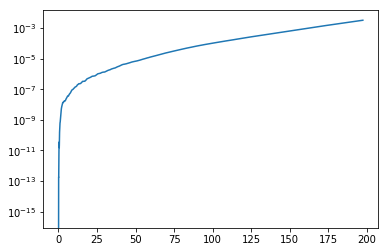

In [74]:
plt.semilogy(tn, np.abs(en_tot - en_tot[0])/en_tot[0])

In [76]:
en_tot

array([0.86390554, 0.86390554, 0.86390554, ..., 0.86675363, 0.86675853,
       0.86676363])

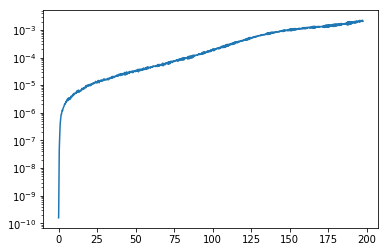

In [80]:
plt.semilogy(tn, en_B)
#plt.xlim((0., 200.))
#plt.ylim((1e-7, 1e-3))
#plt.semilogy(tn, 1e-5*np.exp(2*0.04*tn), 'k--')